In [3]:
!pip install tensorflow
import tensorflow as tf

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/wustl_hdrl_2024 medical dataset.csv')
print("Dataset shape:", df.shape)
print("\nTarget distribution:")
print(df['Label'].value_counts())

Dataset shape: (145123, 77)

Target distribution:
Label
0    132884
1     12239
Name: count, dtype: int64


In [5]:
# Verifying the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145123 entries, 0 to 145122
Data columns (total 77 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Dir                        145123 non-null  object 
 1   Flgs                       145123 non-null  object 
 2   SrcAddr                    145123 non-null  object 
 3   DstAddr                    145123 non-null  object 
 4   Sport                      145123 non-null  object 
 5   Dport                      145123 non-null  int64  
 6   SrcBytes                   145123 non-null  float64
 7   DstBytes                   145123 non-null  float64
 8   SrcLoad                    145123 non-null  float64
 9   DstLoad                    145123 non-null  float64
 10  SrcGap                     145123 non-null  float64
 11  DstGap                     145123 non-null  float64
 12  SIntPkt                    145123 non-null  float64
 13  DIntPkt                    14

In [6]:
# Handling null values of numerics

for col in df.columns:
  if pd.api.types.is_numeric_dtype(df[col]):
    df[col] = df[col].fillna(df[col].mean())
  else:
    df[col] = df[col].fillna(df[col].mode()[0])

In [7]:
# Separating numerical and categorical values
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()

# Remove target from numerical columns if it exists there
if 'Label' in num_cols:
    num_cols.remove('Label')

print("Numerical columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

Numerical columns: 66
Categorical columns: 10


In [8]:
# Create a copy for preprocessing
df_processed = df.copy()

# Scaling numerical data BEFORE train/test split to avoid data leakage
# We'll fit the scaler on training data only later
scaler = StandardScaler()

# Separating cat_cols by cardinality
low_card_cols = [col for col in cat_cols if col != 'Label' and df[col].nunique() <= 100]
high_card_cols = [col for col in cat_cols if col != 'Label' and df[col].nunique() > 100]

print(f"Low cardinality cols: {len(low_card_cols)}")
print(f"High cardinality cols: {len(high_card_cols)}")

# Feature Engineering - but we'll do this properly after train/test split
def preprocess_features(df_train, df_test, num_cols, high_card_cols, low_card_cols):

    # Scale numerical features using only training data
    scaler = StandardScaler()
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()

    df_train_scaled[num_cols] = scaler.fit_transform(df_train[num_cols])
    df_test_scaled[num_cols] = scaler.transform(df_test[num_cols])

    # Frequency encoding for high cardinality - using only training frequencies
    for col in high_card_cols:
        frequency_encoding = df_train[col].value_counts().to_dict()
        df_train_scaled[col] = df_train[col].map(frequency_encoding).fillna(0)
        df_test_scaled[col] = df_test[col].map(frequency_encoding).fillna(0)

    # One-hot encoding for low cardinality
    df_train_encoded = pd.get_dummies(df_train_scaled[low_card_cols], drop_first=True)
    df_test_encoded = pd.get_dummies(df_test_scaled[low_card_cols], drop_first=True)

    # Align columns between train and test
    missing_cols = set(df_train_encoded.columns) - set(df_test_encoded.columns)
    for col in missing_cols:
        df_test_encoded[col] = 0

    extra_cols = set(df_test_encoded.columns) - set(df_train_encoded.columns)
    for col in extra_cols:
        df_test_encoded.drop(col, axis=1, inplace=True)

    df_test_encoded = df_test_encoded[df_train_encoded.columns]

    # Combine all features
    df_train_final = pd.concat([
        df_train_scaled[num_cols],
        df_train_scaled[high_card_cols],
        df_train_encoded
    ], axis=1)

    df_test_final = pd.concat([
        df_test_scaled[num_cols],
        df_test_scaled[high_card_cols],
        df_test_encoded
    ], axis=1)

    return df_train_final, df_test_final

Low cardinality cols: 7
High cardinality cols: 3


In [9]:
# First split the data BEFORE any preprocessing
X = df.drop('Label', axis=1)
y = df['Label']

# Convert labels to binary (0 for normal, 1 for attack)
y_binary = (y != 0).astype(int)

print("\nBinary label distribution:")
print(y_binary.value_counts())

# Train-test split FIRST
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Train label distribution:\n{Y_train.value_counts()}")
print(f"Test label distribution:\n{Y_test.value_counts()}")

# Now preprocess without data leakage
X_train_processed, X_test_processed = preprocess_features(
    X_train, X_test, num_cols, high_card_cols, low_card_cols
)

print(f"\nProcessed train shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")



Binary label distribution:
Label
0    132884
1     12239
Name: count, dtype: int64

Train set size: (116098, 76)
Test set size: (29025, 76)
Train label distribution:
Label
0    106307
1      9791
Name: count, dtype: int64
Test label distribution:
Label
0    26577
1     2448
Name: count, dtype: int64

Processed train shape: (116098, 85)
Processed test shape: (29025, 85)



Generating Correlation Matrix...
Selected 25 features for correlation matrix


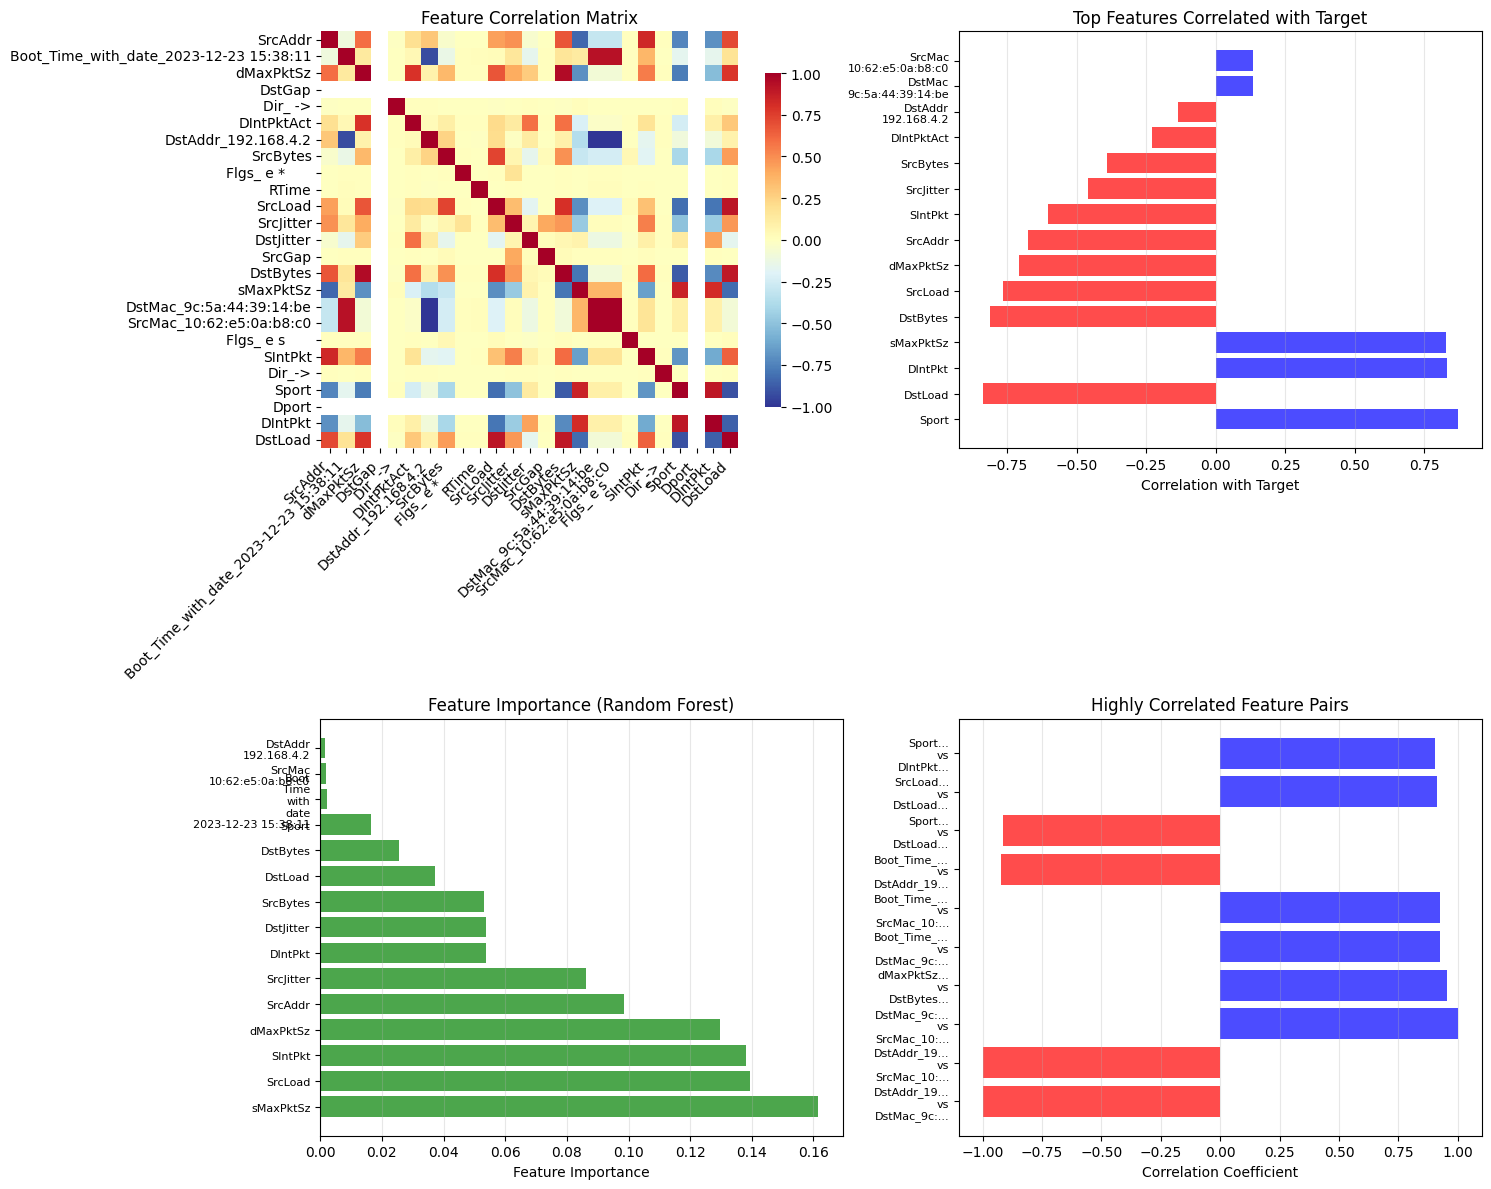

In [10]:
# Correlation Matrix Visualization
print("\nGenerating Correlation Matrix...")
plt.figure(figsize=(15, 12))

# Select a subset of features for correlation matrix (to avoid overcrowding)
# We'll use numerical features and some important categorical features
correlation_features = []

# Add numerical features
correlation_features.extend(num_cols[:15])  # First 15 numerical features

# Add some high cardinality encoded features
if high_card_cols:
    correlation_features.extend([col for col in high_card_cols if col in X_train_processed.columns][:5])

# Add some low cardinality encoded features
low_card_encoded = [col for col in X_train_processed.columns if any(lc in col for lc in low_card_cols)]
correlation_features.extend(low_card_encoded[:10])

# Remove duplicates and ensure features exist
correlation_features = list(set(correlation_features))
correlation_features = [f for f in correlation_features if f in X_train_processed.columns]

# Limit to prevent overcrowding
correlation_features = correlation_features[:25]

print(f"Selected {len(correlation_features)} features for correlation matrix")

# Create correlation matrix
corr_data = X_train_processed[correlation_features].copy()
correlation_matrix = corr_data.corr()

# Plot correlation matrix
plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix,
            annot=False,
            cmap='RdYlBu_r',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Plot correlation with target variable
plt.subplot(2, 2, 2)
# Add target to training data temporarily for correlation
temp_data = X_train_processed[correlation_features].copy()
temp_data['Target'] = Y_train.values
target_corr = temp_data.corr()['Target'].drop('Target').sort_values(key=abs, ascending=False)

# Plot top correlations with target
top_corr = target_corr.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_corr)), [f.replace('_', '\n') for f in top_corr.index], fontsize=8)
plt.xlabel('Correlation with Target')
plt.title('Top Features Correlated with Target')
plt.grid(axis='x', alpha=0.3)

# Plot feature importance (if we have numerical features)
plt.subplot(2, 2, 3)
if len(num_cols) > 0:
    # Quick Random Forest for feature importance
    rf_temp = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_temp.fit(X_train_processed[correlation_features], Y_train)
    feature_importance = pd.Series(rf_temp.feature_importances_, index=correlation_features).sort_values(ascending=False)

    top_importance = feature_importance.head(15)
    plt.barh(range(len(top_importance)), top_importance.values, color='green', alpha=0.7)
    plt.yticks(range(len(top_importance)), [f.replace('_', '\n') for f in top_importance.index], fontsize=8)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (Random Forest)')
    plt.grid(axis='x', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No numerical features\nfor importance plot',
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Feature Importance')

# Plot highly correlated feature pairs
plt.subplot(2, 2, 4)
# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # High correlation threshold
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

if high_corr_pairs:
    # Sort by absolute correlation value
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    high_corr_pairs = high_corr_pairs[:10]  # Top 10 pairs

    pair_names = [f"{pair[0][:10]}...\nvs\n{pair[1][:10]}..." for pair in high_corr_pairs]
    corr_values = [pair[2] for pair in high_corr_pairs]
    colors = ['red' if x < 0 else 'blue' for x in corr_values]

    plt.barh(range(len(corr_values)), corr_values, color=colors, alpha=0.7)
    plt.yticks(range(len(pair_names)), pair_names, fontsize=8)
    plt.xlabel('Correlation Coefficient')
    plt.title('Highly Correlated Feature Pairs')
    plt.grid(axis='x', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No highly correlated\nfeature pairs found\n(threshold: 0.7)',
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.title('High Correlation Pairs')

plt.tight_layout()
plt.show()

In [11]:
# Handle outliers in training data only
def handle_outliers(df):
    df_clean = df.copy()
    for col in df_clean.columns:
        if df_clean[col].dtype in ['float64', 'int64']:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df_clean[col] = df_clean[col].clip(lower=lower, upper=upper)
    return df_clean

X_train_clean = handle_outliers(X_train_processed)

In [12]:
# Spliting data among clients
def split_data(x, y, num_clients):
    client_data = []
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    split_size = len(x) // num_clients

    for i in range(num_clients):
        start = i * split_size
        end = start + split_size if i != num_clients - 1 else len(x)
        client_x = x.iloc[indices[start:end]]
        client_y = y.iloc[indices[start:end]]
        client_data.append((client_x, client_y))
    return client_data

num_clients = 5
client_data = split_data(X_train_clean, Y_train, num_clients)

# Check sizes
for i, (cx, cy) in enumerate(client_data):  # Use lowercase 'client_data'
    print(f"Client {i}: X shape={cx.shape}, Attack rate={cy.mean():.3f}")

Client 0: X shape=(23219, 85), Attack rate=0.084
Client 1: X shape=(23219, 85), Attack rate=0.086
Client 2: X shape=(23219, 85), Attack rate=0.088
Client 3: X shape=(23219, 85), Attack rate=0.081
Client 4: X shape=(23222, 85), Attack rate=0.083


In [13]:
# Define model with proper regularization
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_client_model(model, X_client, y_client, epochs=5):
    history = model.fit(
        X_client, y_client,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    return model.get_weights(), history

def aggregate_weights(client_weights):
    """Average the weights from all clients"""
    averaged_weights = []
    for weights_list_tuple in zip(*client_weights):
        averaged_weights.append(np.mean(np.array(weights_list_tuple), axis=0))
    return averaged_weights

In [14]:
# Federated Learning Loop
global_model = create_model(X_train_clean.shape[1])
global_weights = global_model.get_weights()

num_rounds = 5
num_epochs = 3

print("\nStarting Federated Learning...")
training_history = {'round': [], 'loss': [], 'accuracy': []}

for round_num in range(num_rounds):
    print(f"\nRound {round_num + 1}/{num_rounds}")
    client_weights = []

    for i, (X_client, y_client) in enumerate(client_data):
        # Create fresh model for each client
        client_model = create_model(X_train_clean.shape[1])
        client_model.set_weights(global_weights)

        # Train client model
        client_weight, history = train_client_model(
            client_model, X_client, y_client, epochs=num_epochs
        )
        client_weights.append(client_weight)

        print(f"  Client {i+1} trained - Final accuracy: {history.history['accuracy'][-1]:.4f}")

    # Aggregate weights
    global_weights = aggregate_weights(client_weights)
    global_model.set_weights(global_weights)

    # Evaluate on test data
    loss, accuracy = global_model.evaluate(X_test_processed, Y_test, verbose=0)
    training_history['round'].append(round_num + 1)
    training_history['loss'].append(loss)
    training_history['accuracy'].append(accuracy)

    print(f"Global Model - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Starting Federated Learning...

Round 1/5
  Client 1 trained - Final accuracy: 0.9763
  Client 2 trained - Final accuracy: 0.9776
  Client 3 trained - Final accuracy: 0.9754
  Client 4 trained - Final accuracy: 0.9767
  Client 5 trained - Final accuracy: 0.9784
Global Model - Test Loss: 0.0842, Test Accuracy: 0.9846

Round 2/5
  Client 1 trained - Final accuracy: 0.9856
  Client 2 trained - Final accuracy: 0.9837
  Client 3 trained - Final accuracy: 0.9833
  Client 4 trained - Final accuracy: 0.9843
  Client 5 trained - Final accuracy: 0.9844
Global Model - Test Loss: 0.0809, Test Accuracy: 0.9846

Round 3/5
  Client 1 trained - Final accuracy: 0.9861
  Client 2 trained - Final accuracy: 0.9840
  Client 3 trained - Final accuracy: 0.9833
  Client 4 trained - Final accuracy: 0.9849
  Client 5 trained - Final accuracy: 0.9844
Global Model - Test Loss: 0.0806, Test Accuracy: 0.9846

Round 4/5
  Client 1 trained - Final accuracy: 0.9856
  Client 2 trained - Final accuracy: 0.9840
  Client


FINAL EVALUATION
908/908 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final Test Accuracy: 0.9846
Final Test Accuracy (%): 98.46%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99     26577
      Attack       1.00      0.82      0.90      2448

    accuracy                           0.98     29025
   macro avg       0.99      0.91      0.95     29025
weighted avg       0.98      0.98      0.98     29025



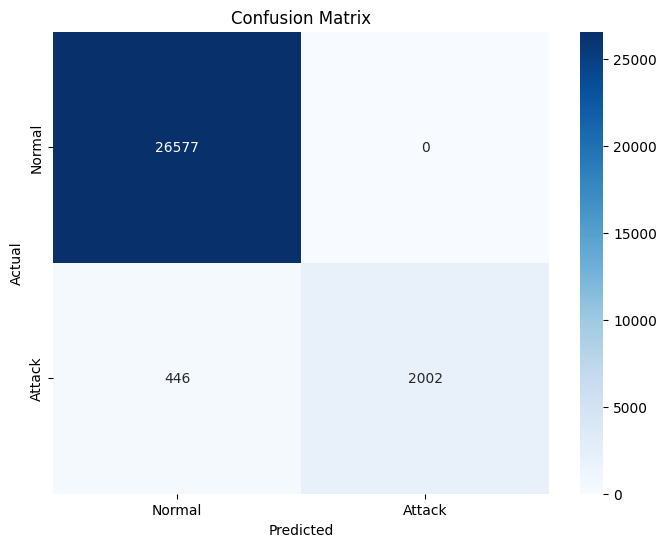

In [15]:
# Final evaluation
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

# Predict on test set
y_pred_probs = global_model.predict(X_test_processed)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final Test Accuracy (%): {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=['Normal', 'Attack']))

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

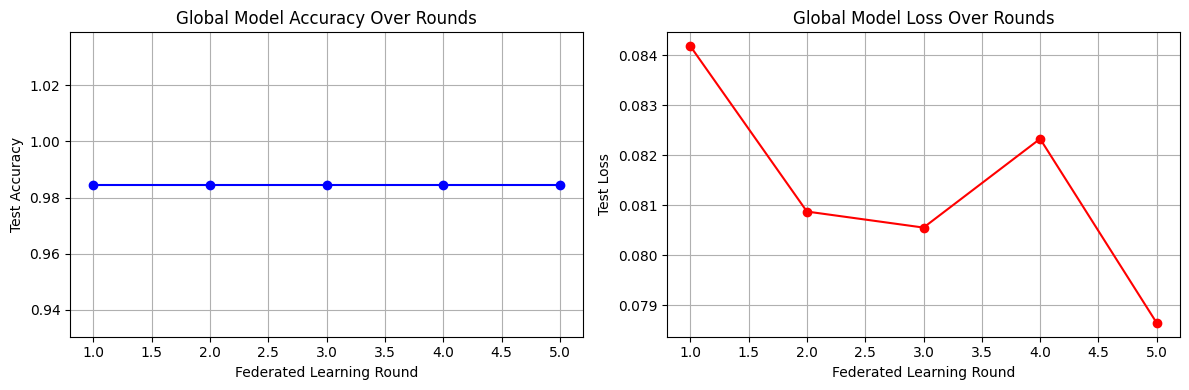

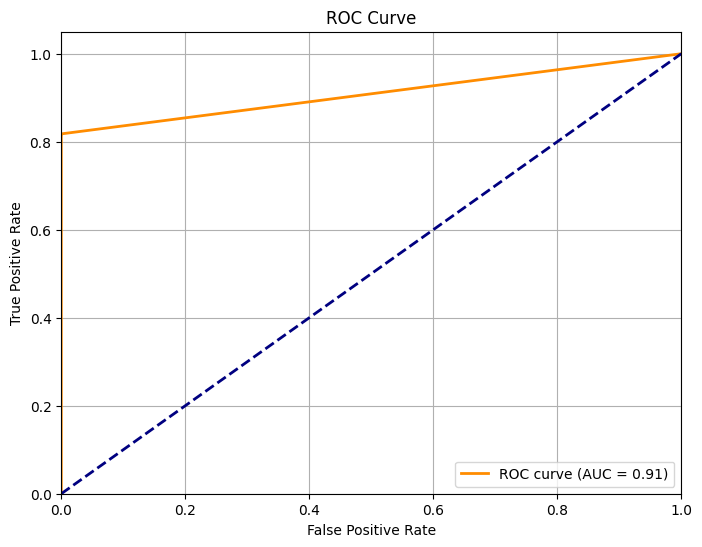


Final Results Summary:
- Test Accuracy: 0.9846 (98.46%)
- AUC Score: 0.9089
- Number of FL Rounds: 5
- Number of Clients: 5


In [16]:
# Training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history['round'], training_history['accuracy'], 'b-o')
plt.title('Global Model Accuracy Over Rounds')
plt.xlabel('Federated Learning Round')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training_history['round'], training_history['loss'], 'r-o')
plt.title('Global Model Loss Over Rounds')
plt.xlabel('Federated Learning Round')
plt.ylabel('Test Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"\nFinal Results Summary:")
print(f"- Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"- AUC Score: {roc_auc:.4f}")
print(f"- Number of FL Rounds: {num_rounds}")
print(f"- Number of Clients: {num_clients}")

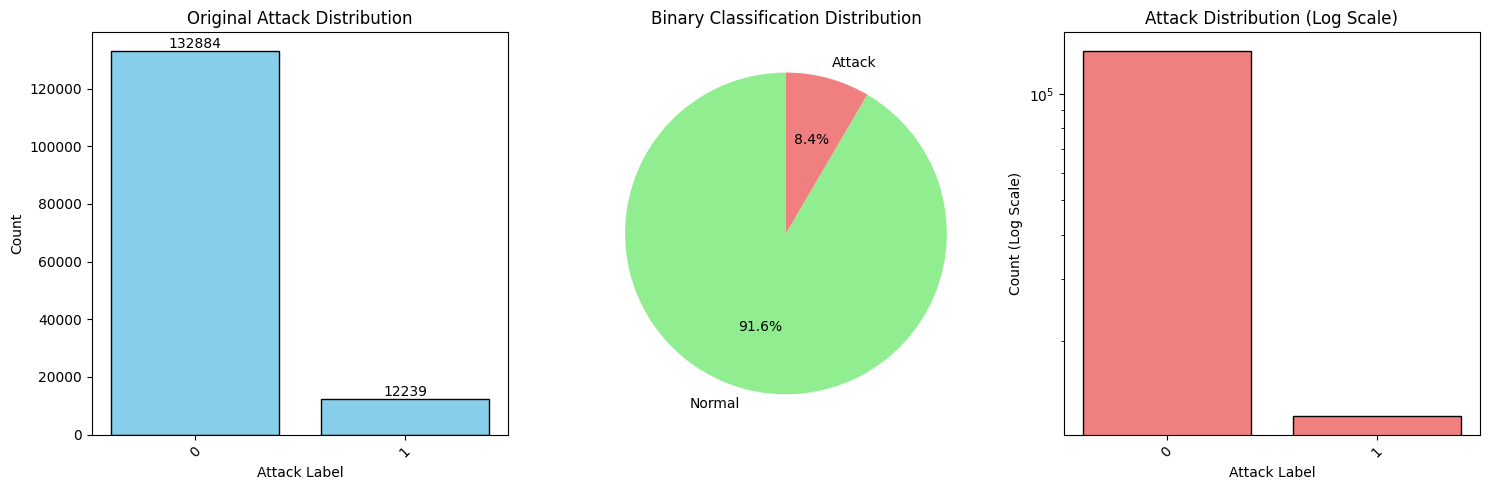

In [21]:
# Attack Distribution Visualization
plt.figure(figsize=(15, 5))

# Plot 1: Original Label Distribution
plt.subplot(1, 3, 1)
label_counts = df['Label'].value_counts().sort_index()
plt.bar(range(len(label_counts)), label_counts.values, color='skyblue', edgecolor='black')
plt.title('Original Attack Distribution')
plt.xlabel('Attack Label')
plt.ylabel('Count')
plt.xticks(range(len(label_counts)), label_counts.index, rotation=45)
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')

# Plot 2: Attack Category Distribution (if exists)
if 'Attack Category' in df.columns:
    plt.subplot(1, 3, 2)
    attack_cat_counts = df['Attack Category'].value_counts()
    plt.pie(attack_cat_counts.values, labels=attack_cat_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Attack Category Distribution')
else:
    plt.subplot(1, 3, 2)
    # Create binary distribution
    binary_dist = df['Label'].apply(lambda x: 'Normal' if x == 0 else 'Attack').value_counts()
    plt.pie(binary_dist.values, labels=binary_dist.index, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
    plt.title('Binary Classification Distribution')

# Plot 3: Log scale for better visualization of imbalanced data
plt.subplot(1, 3, 3)
plt.bar(range(len(label_counts)), label_counts.values, color='lightcoral', edgecolor='black')
plt.title('Attack Distribution (Log Scale)')
plt.xlabel('Attack Label')
plt.ylabel('Count (Log Scale)')
plt.yscale('log')
plt.xticks(range(len(label_counts)), label_counts.index, rotation=45)

plt.tight_layout()
plt.show()